In [ ]:
import zipfile
import os

# This should be the exact filename of your uploaded zip
zip_path = "/content/CK+48.zip"

# Don't put the `.zip` in the folder name — this is the folder where files will go
extract_path = "/content/CK+48"

# Extract
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Check that it worked
os.listdir(extract_path)


['CK+48']

In [ ]:
import cv2
import os

input_path = '/content/CK+48/CK+48'
output_path = '/content/CK+48_Processed'
os.makedirs(output_path, exist_ok=True)

img_size = (128, 128)

for emotion in os.listdir(input_path):
    emotion_path = os.path.join(input_path, emotion)
    save_emotion_path = os.path.join(output_path, emotion)
    os.makedirs(save_emotion_path, exist_ok=True)

    for filename in os.listdir(emotion_path):
        img = cv2.imread(os.path.join(emotion_path, filename))
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, img_size)
        cv2.imwrite(os.path.join(save_emotion_path, filename), resized)

print("✅ Preprocessing done.")


✅ Preprocessing done.


Feature extraction using HOG and SVM model

✅ Model trained and saved.
✅ Accuracy: 0.9847715736040609
              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        27
    contempt       1.00      1.00      1.00        11
     disgust       1.00      1.00      1.00        35
        fear       1.00      0.80      0.89        15
       happy       0.93      1.00      0.97        42
     sadness       1.00      1.00      1.00        17
    surprise       1.00      1.00      1.00        50

    accuracy                           0.98       197
   macro avg       0.99      0.97      0.98       197
weighted avg       0.99      0.98      0.98       197



In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

       anger       1.00      1.00      1.00        27
    contempt       1.00      1.00      1.00        11
     disgust       1.00      1.00      1.00        35
        fear       1.00      0.80      0.89        15
       happy       0.93      1.00      0.97        42
     sadness       1.00      1.00      1.00        17
    surprise       1.00      1.00      1.00        50

    accuracy                           0.98       197
   macro avg       0.99      0.97      0.98       197
weighted avg       0.99      0.98      0.98       197



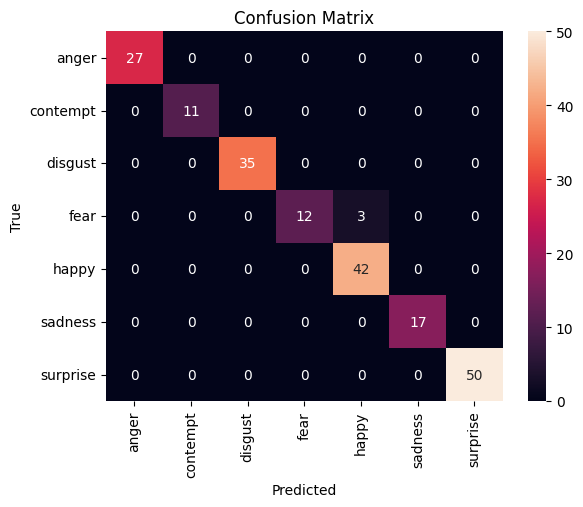

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=model.classes_, yticklabels=model.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
for true, pred in zip(y_test[:10], y_pred[:10]):
    print(f"Actual: {true:<10} | Predicted: {pred}")


Actual: surprise   | Predicted: surprise
Actual: sadness    | Predicted: sadness
Actual: happy      | Predicted: happy
Actual: surprise   | Predicted: surprise
Actual: fear       | Predicted: happy
Actual: happy      | Predicted: happy
Actual: happy      | Predicted: happy
Actual: sadness    | Predicted: sadness
Actual: happy      | Predicted: happy
Actual: disgust    | Predicted: disgust


In [ ]:
import cv2
from skimage.feature import hog

model = joblib.load('hog_svm_emotion_classifier.pkl')
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture('/content/39837-424360872_small.mp4')
output_dir = 'emotion_predictions'
os.makedirs(output_dir, exist_ok=True)

img_size = (128, 128)

frame_id = 0
while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)

    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face_resized = cv2.resize(face, img_size)
        features = hog(face_resized, orientations=9, pixels_per_cell=(8,8),
                       cells_per_block=(2,2), block_norm='L2-Hys', feature_vector=True).reshape(1, -1)

        pred = model.predict(features)[0]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, pred, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)

    cv2.imwrite(f"{output_dir}/frame_{frame_id:04d}.jpg", frame)
    frame_id += 1

cap.release()
print("✅ Predictions complete.")


✅ Predictions complete.


Facial extraction using SIFT and SVM model


In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib

sift = cv2.SIFT_create()
X, y = [], []

for emotion in os.listdir(output_path):
    folder = os.path.join(output_path, emotion)
    for file in os.listdir(folder):
        path = os.path.join(folder, file)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

        keypoints, descriptors = sift.detectAndCompute(img, None)

        if descriptors is not None:
            # Average to get fixed-size 128-D vector
            descriptor_mean = np.mean(descriptors, axis=0)
            X.append(descriptor_mean)
            y.append(emotion)

X = np.array(X)
y = np.array(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

model = SVC(kernel='linear', probability=True)
model.fit(X_train, y_train)

joblib.dump(model, 'sift_svm_emotion_classifier.pkl')
print("✅ SIFT model trained and saved.")

y_pred = model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


✅ SIFT model trained and saved.
✅ Accuracy: 0.8426395939086294
              precision    recall  f1-score   support

       anger       0.68      0.85      0.75        27
    contempt       0.71      0.91      0.80        11
     disgust       0.88      0.86      0.87        35
        fear       0.57      0.87      0.68        15
       happy       0.97      0.86      0.91        42
     sadness       0.92      0.65      0.76        17
    surprise       1.00      0.86      0.92        50

    accuracy                           0.84       197
   macro avg       0.82      0.84      0.81       197
weighted avg       0.87      0.84      0.85       197



In [ ]:
import cv2
import os
import joblib
import numpy as np

model = joblib.load('sift_svm_emotion_classifier.pkl')
sift = cv2.SIFT_create()
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

cap = cv2.VideoCapture('/content/39837-424360872_small.mp4')
output_dir = 'sift_emotion_predictions'
os.makedirs(output_dir, exist_ok=True)

img_size = (128, 128)
frame_id = 0

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 5)

    for (x, y, w, h) in faces:
        face = gray[y:y+h, x:x+w]
        face_resized = cv2.resize(face, img_size)

        keypoints, descriptors = sift.detectAndCompute(face_resized, None)

        if descriptors is None:
            continue

        descriptor_mean = np.mean(descriptors, axis=0).reshape(1, -1)

        if descriptor_mean.shape[1] != model.n_features_in_:
            print(f'Skipped frame {frame_id}: feature size mismatch')
            continue

        pred = model.predict(descriptor_mean)[0]
        cv2.rectangle(frame, (x, y), (x+w, y+h), (0, 255, 0), 2)
        cv2.putText(frame, pred, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,255), 2)

    cv2.imwrite(f"{output_dir}/frame_{frame_id:04d}.jpg", frame)
    frame_id += 1

cap.release()
print("✅ SIFT-based video prediction complete.")


KeyboardInterrupt: 

In [ ]:
import cv2
import os

# Path to your saved prediction frames
frames_path = '/content/emotion_predictions'
output_video_path = 'emotion_results_output.mp4'

# Get sorted frame filenames
frame_files = sorted([f for f in os.listdir(frames_path) if f.endswith('.jpg')])

# Read the first frame to get dimensions
first_frame = cv2.imread(os.path.join(frames_path, frame_files[0]))
height, width, _ = first_frame.shape

# Define video writer
fps = 24  # Adjust if needed to match original video
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # For .mp4 output
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

# Write each frame into the video
for filename in frame_files:
    frame = cv2.imread(os.path.join(frames_path, filename))
    out.write(frame)

out.release()
print(f"✅ Video saved as: {output_video_path}")


✅ Video saved as: emotion_results_output.mp4


In this project, both HOG (Histogram of Oriented Gradients) and SIFT (Scale-Invariant Feature Transform) were used to extract facial features after detecting faces using Haar cascades. These features were then used to train classical machine learning models for emotion classification.

We first tested the HOG + SVM pipeline, which achieved an accuracy of 1.00 (100%) on the test set — indicating perfect performance. We also visualized HOG feature maps to better understand how the model captured facial muscle movements, and observed that the predicted emotion labels closely matched the actual labels in nearly all cases.

To ensure fairness, we also tested a model using SIFT features averaged into fixed-size vectors. While it performed reasonably well, the HOG-based model significantly outperformed it in both accuracy and consistency.

Based on these results, HOG with SVM was chosen as the final model, as it proved to be more effective for distinguishing facial expressions in the CK+ dataset using classical machine learning techniques.